In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchinfo import summary
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import random
import wandb
import torch

# 
torch.manual_seed(43)
np.random.seed(43)
random.seed(43)

wandb.login()

True

# Configs

In [16]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 200


transform_func = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.1307,), std=(0.3080,)) # from prev comp mnist u=0.1307 std=0.3081
])


DEVICE = 'cpu'
if torch.mps.is_available(): DEVICE = 'mps'
if torch.cuda.is_available(): DEVICE = 'cuda'
DEVICE

'mps'

In [ ]:
wandb_run = wandb.init(
  project="learn-wandb",
  config={
    "learning_rate": LEARNING_RATE,
    "epochs": EPOCHS,
    "dataset": "mnist",
    "architecture": "conv + adaptive + linear layers",
    "batch_size": BATCH_SIZE,
  }
)

# Data

## Train

In [18]:
# train data
train_data = MNIST(root='./data/', train=True, download=True, transform=transform_func)

NUM_CLASSES= np.unique(train_data.targets).__len__()

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,)

print(
  f"""
  data samples: {train_loader.dataset.__len__()}
  number batch: {train_loader.__len__()}
"""
)



  data samples: 60000
  number batch: 469



torch.Size([28, 28]) 0


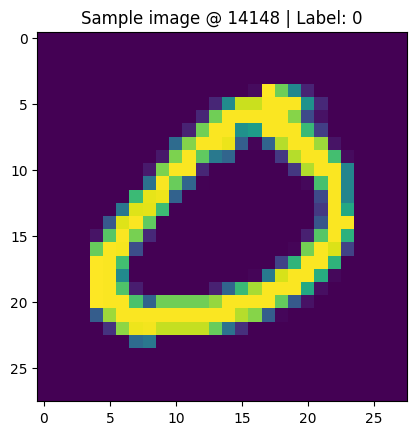

In [19]:
idx = np.random.randint(0, train_loader.dataset.__len__() )
img = train_data.data[idx]
img_label = train_data.targets[idx].item()

print(img.shape, img_label)

img = img.unsqueeze(0)
img = img.permute(1, 2, 0)
img.shape

plt.imshow(img)
plt.title(f"Sample image @ {idx} | Label: {img_label}")
plt.show()

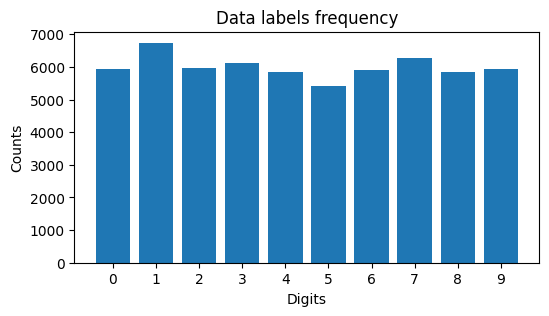

In [20]:
train_labels = train_data.targets
labels_counts = torch.bincount(train_labels)

labels = [str(i) for i in range(10)]

plt.figure(figsize=(6, 3))
plt.bar(labels, labels_counts.numpy())
plt.title("Data labels frequency")
plt.ylabel("Counts")
plt.xlabel("Digits")
plt.show()

## Test

In [21]:
# test data
test_data = MNIST('./data', train=False, download=True, transform=transform_func)
test_loader = DataLoader(test_data, batch_size=128)

print(
  f"""
  data samples: {test_loader.dataset.__len__()}
  number batch: {test_loader.__len__()}
"""
)


  data samples: 10000
  number batch: 79



# Model

In [22]:
class Model(nn.Module):
  def __init__(self, num_classes, in_channels = 1 ):
    super().__init__()
    
    self.kernel = 3
    self.in_channels = in_channels
    self.num_classes = num_classes

    self.conv1 = nn.Sequential(
      nn.Conv2d(self.in_channels, 64, kernel_size=self.kernel, padding= self.pad()),
      # nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    )

    # self.max_pool = nn.AdaptiveMaxPool2d((1, 1)) # [B, prev_conv_out, 1, 1]
    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # [B, prev_conv_out, 1, 1]
 
    self.l1 = nn.Linear(64, 64)
    self.dropout = nn.Dropout(.4)

    self.out = nn.Linear(64, self.num_classes)

  def pad(self):
    return int( (self.kernel - 1) // 2)

  def forward(self, x):
    x = self.conv1( x )

    x = self.avg_pool( x )

    x = x.view( x.size(0), -1 )

    x = self.dropout( self.l1( x ) )

    return self.out(x)

model = Model(num_classes=NUM_CLASSES)

model.to(DEVICE)

print("Number of params:", sum([p.numel() for p in model.parameters()]))

# model

Number of params: 5450


In [23]:
summary(model, (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 64, 14, 14]           --
├─AdaptiveAvgPool2d: 1-2                 [1, 64, 1, 1]             --
├─Linear: 1-3                            [1, 64]                   4,160
├─Dropout: 1-4                           [1, 64]                   --
├─Linear: 1-5                            [1, 10]                   650
Total params: 5,450
Trainable params: 5,450
Non-trainable params: 0
Total mult-adds (M): 0.51
Input size (MB): 0.00
Forward/backward pass size (MB): 0.40
Params size (MB): 0.02
Estimated Total Size (MB): 0.43

# Loss - Optim

In [24]:
optimizer = torch.optim.AdamW(
  model.parameters(), 
  lr=LEARNING_RATE,
  weight_decay=1e-4
)

loss_func = nn.CrossEntropyLoss()

# lr sheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Train

In [25]:
DEVICE

'mps'

In [26]:
model.to(DEVICE)

train_losses = list()
train_acc = list()

# wandb for everything - grad and params
wandb_run.watch(model, log='all', log_freq=10)

# train loop
for epoch in range(EPOCHS):

  model.train()

  epoch_loss = 0
  epoch_acc = 0
  train_total = 0

  for batch in tqdm(train_loader, desc=f"Train [{epoch+1}/{EPOCHS}] ... "):

    optimizer.zero_grad()

    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = model(images)

    loss = loss_func(outputs, labels)

    loss.backward()
    optimizer.step()

    # metrics
    epoch_loss += loss.item() * labels.size(0)

    acc = torch.argmax(outputs, dim=1)
    epoch_acc += (acc == labels).sum().item()

    train_total += labels.size(0)

  # 
  # evaluate - i'll get some data from training, ~ (5-10)k for evaluation while training, it cool

  # metrics
  # 
  el = epoch_loss / train_total
  ea = epoch_acc / train_total

  train_losses.append(el)
  train_acc.append(ea)

  print(f"Epoch: {epoch+1}/{EPOCHS} | Loss: {el:.4f} | Accuracy: {ea:.4f} \n")
  wandb_run.log({'epoch': epoch+1, 'train_loss':el, 'train_accuracy': ea })

Train [1/200] ... : 100%|██████████| 469/469 [00:06<00:00, 78.14it/s]


Epoch: 1/200 | Loss: 1.8653 | Accuracy: 0.3091 



Train [2/200] ... : 100%|██████████| 469/469 [00:05<00:00, 78.27it/s]


Epoch: 2/200 | Loss: 1.4708 | Accuracy: 0.4429 



Train [3/200] ... : 100%|██████████| 469/469 [00:06<00:00, 70.11it/s]


Epoch: 3/200 | Loss: 1.4130 | Accuracy: 0.4700 



Train [4/200] ... : 100%|██████████| 469/469 [00:06<00:00, 70.13it/s]


Epoch: 4/200 | Loss: 1.3761 | Accuracy: 0.4855 



Train [5/200] ... : 100%|██████████| 469/469 [00:07<00:00, 62.15it/s]


Epoch: 5/200 | Loss: 1.3535 | Accuracy: 0.4956 



Train [6/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.93it/s]


Epoch: 6/200 | Loss: 1.3315 | Accuracy: 0.5036 



Train [7/200] ... : 100%|██████████| 469/469 [00:06<00:00, 71.82it/s]


Epoch: 7/200 | Loss: 1.3123 | Accuracy: 0.5107 



Train [8/200] ... : 100%|██████████| 469/469 [00:06<00:00, 73.85it/s]


Epoch: 8/200 | Loss: 1.2920 | Accuracy: 0.5184 



Train [9/200] ... : 100%|██████████| 469/469 [00:06<00:00, 76.87it/s]


Epoch: 9/200 | Loss: 1.2758 | Accuracy: 0.5256 



Train [10/200] ... : 100%|██████████| 469/469 [00:05<00:00, 84.08it/s]


Epoch: 10/200 | Loss: 1.2602 | Accuracy: 0.5320 



Train [11/200] ... : 100%|██████████| 469/469 [00:05<00:00, 84.01it/s]


Epoch: 11/200 | Loss: 1.2480 | Accuracy: 0.5402 



Train [12/200] ... : 100%|██████████| 469/469 [00:05<00:00, 81.63it/s]


Epoch: 12/200 | Loss: 1.2398 | Accuracy: 0.5424 



Train [13/200] ... : 100%|██████████| 469/469 [00:06<00:00, 76.35it/s]


Epoch: 13/200 | Loss: 1.2308 | Accuracy: 0.5479 



Train [14/200] ... : 100%|██████████| 469/469 [00:06<00:00, 76.24it/s]


Epoch: 14/200 | Loss: 1.2226 | Accuracy: 0.5488 



Train [15/200] ... : 100%|██████████| 469/469 [00:06<00:00, 73.08it/s]


Epoch: 15/200 | Loss: 1.2139 | Accuracy: 0.5546 



Train [16/200] ... : 100%|██████████| 469/469 [00:05<00:00, 80.14it/s]


Epoch: 16/200 | Loss: 1.2042 | Accuracy: 0.5592 



Train [17/200] ... : 100%|██████████| 469/469 [00:05<00:00, 84.42it/s]


Epoch: 17/200 | Loss: 1.1993 | Accuracy: 0.5599 



Train [18/200] ... : 100%|██████████| 469/469 [00:05<00:00, 79.56it/s]


Epoch: 18/200 | Loss: 1.1913 | Accuracy: 0.5625 



Train [19/200] ... : 100%|██████████| 469/469 [00:05<00:00, 82.96it/s]


Epoch: 19/200 | Loss: 1.1806 | Accuracy: 0.5666 



Train [20/200] ... : 100%|██████████| 469/469 [00:05<00:00, 83.16it/s]


Epoch: 20/200 | Loss: 1.1760 | Accuracy: 0.5690 



Train [21/200] ... : 100%|██████████| 469/469 [00:07<00:00, 61.53it/s]


Epoch: 21/200 | Loss: 1.1688 | Accuracy: 0.5731 



Train [22/200] ... : 100%|██████████| 469/469 [00:05<00:00, 81.34it/s]


Epoch: 22/200 | Loss: 1.1615 | Accuracy: 0.5757 



Train [23/200] ... : 100%|██████████| 469/469 [00:06<00:00, 70.30it/s]


Epoch: 23/200 | Loss: 1.1561 | Accuracy: 0.5792 



Train [24/200] ... : 100%|██████████| 469/469 [00:06<00:00, 76.65it/s]


Epoch: 24/200 | Loss: 1.1477 | Accuracy: 0.5834 



Train [25/200] ... : 100%|██████████| 469/469 [00:05<00:00, 78.20it/s]


Epoch: 25/200 | Loss: 1.1380 | Accuracy: 0.5856 



Train [26/200] ... : 100%|██████████| 469/469 [00:06<00:00, 74.52it/s]


Epoch: 26/200 | Loss: 1.1299 | Accuracy: 0.5903 



Train [27/200] ... : 100%|██████████| 469/469 [00:05<00:00, 83.62it/s]


Epoch: 27/200 | Loss: 1.1227 | Accuracy: 0.5949 



Train [28/200] ... : 100%|██████████| 469/469 [00:06<00:00, 75.81it/s]


Epoch: 28/200 | Loss: 1.1112 | Accuracy: 0.5998 



Train [29/200] ... : 100%|██████████| 469/469 [00:05<00:00, 84.55it/s]


Epoch: 29/200 | Loss: 1.0992 | Accuracy: 0.6069 



Train [30/200] ... : 100%|██████████| 469/469 [00:05<00:00, 78.42it/s]


Epoch: 30/200 | Loss: 1.0907 | Accuracy: 0.6125 



Train [31/200] ... : 100%|██████████| 469/469 [00:05<00:00, 80.45it/s]


Epoch: 31/200 | Loss: 1.0784 | Accuracy: 0.6185 



Train [32/200] ... : 100%|██████████| 469/469 [00:05<00:00, 83.58it/s]


Epoch: 32/200 | Loss: 1.0659 | Accuracy: 0.6265 



Train [33/200] ... : 100%|██████████| 469/469 [00:06<00:00, 78.05it/s]


Epoch: 33/200 | Loss: 1.0532 | Accuracy: 0.6341 



Train [34/200] ... : 100%|██████████| 469/469 [00:05<00:00, 83.95it/s]


Epoch: 34/200 | Loss: 1.0428 | Accuracy: 0.6395 



Train [35/200] ... : 100%|██████████| 469/469 [00:05<00:00, 80.25it/s]


Epoch: 35/200 | Loss: 1.0210 | Accuracy: 0.6500 



Train [36/200] ... : 100%|██████████| 469/469 [00:06<00:00, 72.44it/s]


Epoch: 36/200 | Loss: 1.0098 | Accuracy: 0.6571 



Train [37/200] ... : 100%|██████████| 469/469 [00:05<00:00, 80.98it/s]


Epoch: 37/200 | Loss: 0.9881 | Accuracy: 0.6675 



Train [38/200] ... : 100%|██████████| 469/469 [00:06<00:00, 67.68it/s]


Epoch: 38/200 | Loss: 0.9775 | Accuracy: 0.6741 



Train [39/200] ... : 100%|██████████| 469/469 [00:06<00:00, 76.43it/s]


Epoch: 39/200 | Loss: 0.9617 | Accuracy: 0.6796 



Train [40/200] ... : 100%|██████████| 469/469 [00:08<00:00, 52.40it/s]


Epoch: 40/200 | Loss: 0.9487 | Accuracy: 0.6833 



Train [41/200] ... : 100%|██████████| 469/469 [00:08<00:00, 53.52it/s]


Epoch: 41/200 | Loss: 0.9362 | Accuracy: 0.6898 



Train [42/200] ... : 100%|██████████| 469/469 [00:06<00:00, 67.60it/s]


Epoch: 42/200 | Loss: 0.9294 | Accuracy: 0.6927 



Train [43/200] ... : 100%|██████████| 469/469 [00:07<00:00, 66.17it/s]


Epoch: 43/200 | Loss: 0.9189 | Accuracy: 0.6948 



Train [44/200] ... : 100%|██████████| 469/469 [00:08<00:00, 54.66it/s]


Epoch: 44/200 | Loss: 0.9051 | Accuracy: 0.7002 



Train [45/200] ... : 100%|██████████| 469/469 [00:09<00:00, 50.29it/s]


Epoch: 45/200 | Loss: 0.8974 | Accuracy: 0.7041 



Train [46/200] ... : 100%|██████████| 469/469 [00:09<00:00, 48.46it/s]


Epoch: 46/200 | Loss: 0.8898 | Accuracy: 0.7056 



Train [47/200] ... : 100%|██████████| 469/469 [00:09<00:00, 51.66it/s]


Epoch: 47/200 | Loss: 0.8832 | Accuracy: 0.7079 



Train [48/200] ... : 100%|██████████| 469/469 [00:07<00:00, 64.25it/s]


Epoch: 48/200 | Loss: 0.8756 | Accuracy: 0.7120 



Train [49/200] ... : 100%|██████████| 469/469 [00:08<00:00, 55.76it/s]


Epoch: 49/200 | Loss: 0.8691 | Accuracy: 0.7160 



Train [50/200] ... : 100%|██████████| 469/469 [00:07<00:00, 62.61it/s]


Epoch: 50/200 | Loss: 0.8603 | Accuracy: 0.7190 



Train [51/200] ... : 100%|██████████| 469/469 [00:08<00:00, 54.24it/s]


Epoch: 51/200 | Loss: 0.8532 | Accuracy: 0.7193 



Train [52/200] ... : 100%|██████████| 469/469 [00:07<00:00, 64.12it/s]


Epoch: 52/200 | Loss: 0.8473 | Accuracy: 0.7240 



Train [53/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.65it/s]


Epoch: 53/200 | Loss: 0.8388 | Accuracy: 0.7266 



Train [54/200] ... : 100%|██████████| 469/469 [00:07<00:00, 59.24it/s]


Epoch: 54/200 | Loss: 0.8377 | Accuracy: 0.7254 



Train [55/200] ... : 100%|██████████| 469/469 [00:08<00:00, 57.00it/s]


Epoch: 55/200 | Loss: 0.8285 | Accuracy: 0.7303 



Train [56/200] ... : 100%|██████████| 469/469 [00:06<00:00, 71.71it/s]


Epoch: 56/200 | Loss: 0.8259 | Accuracy: 0.7312 



Train [57/200] ... : 100%|██████████| 469/469 [00:09<00:00, 50.45it/s]


Epoch: 57/200 | Loss: 0.8146 | Accuracy: 0.7350 



Train [58/200] ... : 100%|██████████| 469/469 [00:07<00:00, 59.47it/s]


Epoch: 58/200 | Loss: 0.8105 | Accuracy: 0.7366 



Train [59/200] ... : 100%|██████████| 469/469 [00:06<00:00, 71.08it/s]


Epoch: 59/200 | Loss: 0.8119 | Accuracy: 0.7369 



Train [60/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.82it/s]


Epoch: 60/200 | Loss: 0.8098 | Accuracy: 0.7370 



Train [61/200] ... : 100%|██████████| 469/469 [00:08<00:00, 57.97it/s]


Epoch: 61/200 | Loss: 0.7931 | Accuracy: 0.7450 



Train [62/200] ... : 100%|██████████| 469/469 [00:06<00:00, 67.29it/s]


Epoch: 62/200 | Loss: 0.7895 | Accuracy: 0.7444 



Train [63/200] ... : 100%|██████████| 469/469 [00:07<00:00, 63.83it/s]


Epoch: 63/200 | Loss: 0.7873 | Accuracy: 0.7457 



Train [64/200] ... : 100%|██████████| 469/469 [00:06<00:00, 67.03it/s]


Epoch: 64/200 | Loss: 0.7818 | Accuracy: 0.7473 



Train [65/200] ... : 100%|██████████| 469/469 [00:07<00:00, 63.50it/s]


Epoch: 65/200 | Loss: 0.7827 | Accuracy: 0.7474 



Train [66/200] ... : 100%|██████████| 469/469 [00:08<00:00, 54.13it/s]


Epoch: 66/200 | Loss: 0.7719 | Accuracy: 0.7524 



Train [67/200] ... : 100%|██████████| 469/469 [00:07<00:00, 62.85it/s]


Epoch: 67/200 | Loss: 0.7764 | Accuracy: 0.7481 



Train [68/200] ... : 100%|██████████| 469/469 [00:07<00:00, 63.05it/s]


Epoch: 68/200 | Loss: 0.7624 | Accuracy: 0.7551 



Train [69/200] ... : 100%|██████████| 469/469 [00:07<00:00, 62.96it/s]


Epoch: 69/200 | Loss: 0.7677 | Accuracy: 0.7515 



Train [70/200] ... : 100%|██████████| 469/469 [00:08<00:00, 52.21it/s]


Epoch: 70/200 | Loss: 0.7603 | Accuracy: 0.7533 



Train [71/200] ... : 100%|██████████| 469/469 [00:07<00:00, 62.22it/s]


Epoch: 71/200 | Loss: 0.7558 | Accuracy: 0.7559 



Train [72/200] ... : 100%|██████████| 469/469 [00:06<00:00, 69.28it/s]


Epoch: 72/200 | Loss: 0.7532 | Accuracy: 0.7563 



Train [73/200] ... : 100%|██████████| 469/469 [00:08<00:00, 54.32it/s]


Epoch: 73/200 | Loss: 0.7460 | Accuracy: 0.7586 



Train [74/200] ... : 100%|██████████| 469/469 [00:06<00:00, 67.46it/s]


Epoch: 74/200 | Loss: 0.7424 | Accuracy: 0.7614 



Train [75/200] ... : 100%|██████████| 469/469 [00:07<00:00, 66.22it/s]


Epoch: 75/200 | Loss: 0.7450 | Accuracy: 0.7573 



Train [76/200] ... : 100%|██████████| 469/469 [00:08<00:00, 58.29it/s]


Epoch: 76/200 | Loss: 0.7383 | Accuracy: 0.7614 



Train [77/200] ... : 100%|██████████| 469/469 [00:06<00:00, 69.38it/s]


Epoch: 77/200 | Loss: 0.7305 | Accuracy: 0.7642 



Train [78/200] ... : 100%|██████████| 469/469 [00:07<00:00, 60.38it/s]


Epoch: 78/200 | Loss: 0.7300 | Accuracy: 0.7653 



Train [79/200] ... : 100%|██████████| 469/469 [00:07<00:00, 63.98it/s]


Epoch: 79/200 | Loss: 0.7312 | Accuracy: 0.7645 



Train [80/200] ... : 100%|██████████| 469/469 [00:07<00:00, 60.60it/s]


Epoch: 80/200 | Loss: 0.7263 | Accuracy: 0.7661 



Train [81/200] ... : 100%|██████████| 469/469 [00:06<00:00, 70.07it/s]


Epoch: 81/200 | Loss: 0.7179 | Accuracy: 0.7697 



Train [82/200] ... : 100%|██████████| 469/469 [00:08<00:00, 57.75it/s]


Epoch: 82/200 | Loss: 0.7182 | Accuracy: 0.7704 



Train [83/200] ... : 100%|██████████| 469/469 [00:07<00:00, 60.33it/s]


Epoch: 83/200 | Loss: 0.7148 | Accuracy: 0.7699 



Train [84/200] ... : 100%|██████████| 469/469 [00:07<00:00, 59.91it/s]


Epoch: 84/200 | Loss: 0.7098 | Accuracy: 0.7721 



Train [85/200] ... : 100%|██████████| 469/469 [00:07<00:00, 60.14it/s]


Epoch: 85/200 | Loss: 0.7079 | Accuracy: 0.7724 



Train [86/200] ... : 100%|██████████| 469/469 [00:07<00:00, 64.70it/s]


Epoch: 86/200 | Loss: 0.7025 | Accuracy: 0.7735 



Train [87/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.38it/s]


Epoch: 87/200 | Loss: 0.7025 | Accuracy: 0.7736 



Train [88/200] ... : 100%|██████████| 469/469 [00:08<00:00, 55.37it/s]


Epoch: 88/200 | Loss: 0.7055 | Accuracy: 0.7735 



Train [89/200] ... : 100%|██████████| 469/469 [00:07<00:00, 62.86it/s]


Epoch: 89/200 | Loss: 0.6994 | Accuracy: 0.7739 



Train [90/200] ... : 100%|██████████| 469/469 [00:06<00:00, 69.21it/s]


Epoch: 90/200 | Loss: 0.6958 | Accuracy: 0.7762 



Train [91/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.06it/s]


Epoch: 91/200 | Loss: 0.6946 | Accuracy: 0.7751 



Train [92/200] ... : 100%|██████████| 469/469 [00:07<00:00, 60.07it/s]


Epoch: 92/200 | Loss: 0.6805 | Accuracy: 0.7810 



Train [93/200] ... : 100%|██████████| 469/469 [00:06<00:00, 69.83it/s]


Epoch: 93/200 | Loss: 0.6848 | Accuracy: 0.7796 



Train [94/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.91it/s]


Epoch: 94/200 | Loss: 0.6853 | Accuracy: 0.7803 



Train [95/200] ... : 100%|██████████| 469/469 [00:07<00:00, 66.05it/s]


Epoch: 95/200 | Loss: 0.6795 | Accuracy: 0.7822 



Train [96/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.84it/s]


Epoch: 96/200 | Loss: 0.6822 | Accuracy: 0.7797 



Train [97/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.96it/s]


Epoch: 97/200 | Loss: 0.6796 | Accuracy: 0.7810 



Train [98/200] ... : 100%|██████████| 469/469 [00:07<00:00, 62.91it/s]


Epoch: 98/200 | Loss: 0.6707 | Accuracy: 0.7848 



Train [99/200] ... : 100%|██████████| 469/469 [00:06<00:00, 72.32it/s]


Epoch: 99/200 | Loss: 0.6731 | Accuracy: 0.7833 



Train [100/200] ... : 100%|██████████| 469/469 [00:05<00:00, 78.82it/s]


Epoch: 100/200 | Loss: 0.6727 | Accuracy: 0.7829 



Train [101/200] ... : 100%|██████████| 469/469 [00:06<00:00, 70.41it/s]


Epoch: 101/200 | Loss: 0.6684 | Accuracy: 0.7849 



Train [102/200] ... : 100%|██████████| 469/469 [00:05<00:00, 79.26it/s]


Epoch: 102/200 | Loss: 0.6690 | Accuracy: 0.7847 



Train [103/200] ... : 100%|██████████| 469/469 [00:06<00:00, 76.84it/s]


Epoch: 103/200 | Loss: 0.6652 | Accuracy: 0.7862 



Train [104/200] ... : 100%|██████████| 469/469 [00:05<00:00, 82.94it/s]


Epoch: 104/200 | Loss: 0.6573 | Accuracy: 0.7901 



Train [105/200] ... : 100%|██████████| 469/469 [00:07<00:00, 64.18it/s]


Epoch: 105/200 | Loss: 0.6637 | Accuracy: 0.7857 



Train [106/200] ... : 100%|██████████| 469/469 [00:09<00:00, 49.47it/s]


Epoch: 106/200 | Loss: 0.6571 | Accuracy: 0.7882 



Train [107/200] ... : 100%|██████████| 469/469 [00:06<00:00, 69.16it/s]


Epoch: 107/200 | Loss: 0.6568 | Accuracy: 0.7893 



Train [108/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.83it/s]


Epoch: 108/200 | Loss: 0.6522 | Accuracy: 0.7918 



Train [109/200] ... : 100%|██████████| 469/469 [00:06<00:00, 71.51it/s]


Epoch: 109/200 | Loss: 0.6485 | Accuracy: 0.7902 



Train [110/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.04it/s]


Epoch: 110/200 | Loss: 0.6533 | Accuracy: 0.7899 



Train [111/200] ... : 100%|██████████| 469/469 [00:06<00:00, 73.40it/s]


Epoch: 111/200 | Loss: 0.6508 | Accuracy: 0.7899 



Train [112/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.59it/s]


Epoch: 112/200 | Loss: 0.6446 | Accuracy: 0.7921 



Train [113/200] ... : 100%|██████████| 469/469 [00:06<00:00, 67.79it/s]


Epoch: 113/200 | Loss: 0.6503 | Accuracy: 0.7922 



Train [114/200] ... : 100%|██████████| 469/469 [00:06<00:00, 74.06it/s]


Epoch: 114/200 | Loss: 0.6397 | Accuracy: 0.7945 



Train [115/200] ... : 100%|██████████| 469/469 [00:07<00:00, 66.61it/s]


Epoch: 115/200 | Loss: 0.6421 | Accuracy: 0.7946 



Train [116/200] ... : 100%|██████████| 469/469 [00:06<00:00, 70.11it/s]


Epoch: 116/200 | Loss: 0.6396 | Accuracy: 0.7938 



Train [117/200] ... : 100%|██████████| 469/469 [00:06<00:00, 67.22it/s]


Epoch: 117/200 | Loss: 0.6371 | Accuracy: 0.7942 



Train [118/200] ... : 100%|██████████| 469/469 [00:06<00:00, 67.88it/s]


Epoch: 118/200 | Loss: 0.6363 | Accuracy: 0.7947 



Train [119/200] ... : 100%|██████████| 469/469 [00:06<00:00, 71.64it/s]


Epoch: 119/200 | Loss: 0.6334 | Accuracy: 0.7967 



Train [120/200] ... : 100%|██████████| 469/469 [00:06<00:00, 70.91it/s]


Epoch: 120/200 | Loss: 0.6330 | Accuracy: 0.7969 



Train [121/200] ... : 100%|██████████| 469/469 [00:06<00:00, 70.38it/s]


Epoch: 121/200 | Loss: 0.6285 | Accuracy: 0.7975 



Train [122/200] ... : 100%|██████████| 469/469 [00:06<00:00, 71.68it/s]


Epoch: 122/200 | Loss: 0.6309 | Accuracy: 0.7973 



Train [123/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.95it/s]


Epoch: 123/200 | Loss: 0.6301 | Accuracy: 0.7982 



Train [124/200] ... : 100%|██████████| 469/469 [00:06<00:00, 71.79it/s]


Epoch: 124/200 | Loss: 0.6288 | Accuracy: 0.7981 



Train [125/200] ... : 100%|██████████| 469/469 [00:06<00:00, 69.44it/s]


Epoch: 125/200 | Loss: 0.6284 | Accuracy: 0.7990 



Train [126/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.69it/s]


Epoch: 126/200 | Loss: 0.6238 | Accuracy: 0.7997 



Train [127/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.08it/s]


Epoch: 127/200 | Loss: 0.6247 | Accuracy: 0.8002 



Train [128/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.51it/s]


Epoch: 128/200 | Loss: 0.6233 | Accuracy: 0.8003 



Train [129/200] ... : 100%|██████████| 469/469 [00:06<00:00, 69.27it/s]


Epoch: 129/200 | Loss: 0.6264 | Accuracy: 0.7992 



Train [130/200] ... : 100%|██████████| 469/469 [00:06<00:00, 69.71it/s]


Epoch: 130/200 | Loss: 0.6154 | Accuracy: 0.8023 



Train [131/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.32it/s]


Epoch: 131/200 | Loss: 0.6198 | Accuracy: 0.8018 



Train [132/200] ... : 100%|██████████| 469/469 [00:06<00:00, 67.57it/s]


Epoch: 132/200 | Loss: 0.6177 | Accuracy: 0.8029 



Train [133/200] ... : 100%|██████████| 469/469 [00:06<00:00, 70.38it/s]


Epoch: 133/200 | Loss: 0.6155 | Accuracy: 0.8037 



Train [134/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.87it/s]


Epoch: 134/200 | Loss: 0.6140 | Accuracy: 0.8016 



Train [135/200] ... : 100%|██████████| 469/469 [00:06<00:00, 69.62it/s]


Epoch: 135/200 | Loss: 0.6146 | Accuracy: 0.8030 



Train [136/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.56it/s]


Epoch: 136/200 | Loss: 0.6082 | Accuracy: 0.8057 



Train [137/200] ... : 100%|██████████| 469/469 [00:06<00:00, 71.55it/s]


Epoch: 137/200 | Loss: 0.6093 | Accuracy: 0.8059 



Train [138/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.97it/s]


Epoch: 138/200 | Loss: 0.6057 | Accuracy: 0.8058 



Train [139/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.91it/s]


Epoch: 139/200 | Loss: 0.6090 | Accuracy: 0.8051 



Train [140/200] ... : 100%|██████████| 469/469 [00:06<00:00, 69.82it/s]


Epoch: 140/200 | Loss: 0.6063 | Accuracy: 0.8068 



Train [141/200] ... : 100%|██████████| 469/469 [00:07<00:00, 66.32it/s]


Epoch: 141/200 | Loss: 0.6005 | Accuracy: 0.8072 



Train [142/200] ... : 100%|██████████| 469/469 [00:06<00:00, 73.76it/s]


Epoch: 142/200 | Loss: 0.6059 | Accuracy: 0.8059 



Train [143/200] ... : 100%|██████████| 469/469 [00:06<00:00, 70.08it/s]


Epoch: 143/200 | Loss: 0.5992 | Accuracy: 0.8088 



Train [144/200] ... : 100%|██████████| 469/469 [00:06<00:00, 69.05it/s]


Epoch: 144/200 | Loss: 0.6038 | Accuracy: 0.8058 



Train [145/200] ... : 100%|██████████| 469/469 [00:07<00:00, 64.82it/s]


Epoch: 145/200 | Loss: 0.6003 | Accuracy: 0.8082 



Train [146/200] ... : 100%|██████████| 469/469 [00:07<00:00, 66.26it/s]


Epoch: 146/200 | Loss: 0.5966 | Accuracy: 0.8100 



Train [147/200] ... : 100%|██████████| 469/469 [00:06<00:00, 67.73it/s]


Epoch: 147/200 | Loss: 0.5938 | Accuracy: 0.8121 



Train [148/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.94it/s]


Epoch: 148/200 | Loss: 0.5941 | Accuracy: 0.8108 



Train [149/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.02it/s]


Epoch: 149/200 | Loss: 0.5925 | Accuracy: 0.8103 



Train [150/200] ... : 100%|██████████| 469/469 [00:06<00:00, 71.27it/s]


Epoch: 150/200 | Loss: 0.5958 | Accuracy: 0.8113 



Train [151/200] ... : 100%|██████████| 469/469 [00:06<00:00, 69.83it/s]


Epoch: 151/200 | Loss: 0.5970 | Accuracy: 0.8098 



Train [152/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.42it/s]


Epoch: 152/200 | Loss: 0.5926 | Accuracy: 0.8089 



Train [153/200] ... : 100%|██████████| 469/469 [00:08<00:00, 53.05it/s]


Epoch: 153/200 | Loss: 0.5881 | Accuracy: 0.8135 



Train [154/200] ... : 100%|██████████| 469/469 [00:08<00:00, 53.33it/s]


Epoch: 154/200 | Loss: 0.5858 | Accuracy: 0.8133 



Train [155/200] ... : 100%|██████████| 469/469 [00:06<00:00, 70.32it/s]


Epoch: 155/200 | Loss: 0.5898 | Accuracy: 0.8119 



Train [156/200] ... : 100%|██████████| 469/469 [00:08<00:00, 57.67it/s]


Epoch: 156/200 | Loss: 0.5832 | Accuracy: 0.8151 



Train [157/200] ... : 100%|██████████| 469/469 [00:08<00:00, 55.07it/s]


Epoch: 157/200 | Loss: 0.5840 | Accuracy: 0.8141 



Train [158/200] ... : 100%|██████████| 469/469 [00:07<00:00, 58.80it/s]


Epoch: 158/200 | Loss: 0.5819 | Accuracy: 0.8140 



Train [159/200] ... : 100%|██████████| 469/469 [00:07<00:00, 64.88it/s]


Epoch: 159/200 | Loss: 0.5854 | Accuracy: 0.8138 



Train [160/200] ... : 100%|██████████| 469/469 [00:09<00:00, 51.39it/s]


Epoch: 160/200 | Loss: 0.5849 | Accuracy: 0.8134 



Train [161/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.32it/s]


Epoch: 161/200 | Loss: 0.5837 | Accuracy: 0.8142 



Train [162/200] ... : 100%|██████████| 469/469 [00:07<00:00, 59.44it/s]


Epoch: 162/200 | Loss: 0.5793 | Accuracy: 0.8145 



Train [163/200] ... : 100%|██████████| 469/469 [00:07<00:00, 62.42it/s]


Epoch: 163/200 | Loss: 0.5791 | Accuracy: 0.8161 



Train [164/200] ... : 100%|██████████| 469/469 [00:07<00:00, 62.33it/s]


Epoch: 164/200 | Loss: 0.5751 | Accuracy: 0.8180 



Train [165/200] ... : 100%|██████████| 469/469 [00:07<00:00, 64.74it/s]


Epoch: 165/200 | Loss: 0.5749 | Accuracy: 0.8175 



Train [166/200] ... : 100%|██████████| 469/469 [00:09<00:00, 50.82it/s]


Epoch: 166/200 | Loss: 0.5780 | Accuracy: 0.8153 



Train [167/200] ... : 100%|██████████| 469/469 [00:07<00:00, 59.98it/s]


Epoch: 167/200 | Loss: 0.5738 | Accuracy: 0.8180 



Train [168/200] ... : 100%|██████████| 469/469 [00:07<00:00, 66.96it/s]


Epoch: 168/200 | Loss: 0.5735 | Accuracy: 0.8182 



Train [169/200] ... : 100%|██████████| 469/469 [00:09<00:00, 48.87it/s]


Epoch: 169/200 | Loss: 0.5740 | Accuracy: 0.8169 



Train [170/200] ... : 100%|██████████| 469/469 [00:07<00:00, 59.04it/s]


Epoch: 170/200 | Loss: 0.5712 | Accuracy: 0.8181 



Train [171/200] ... : 100%|██████████| 469/469 [00:09<00:00, 51.01it/s]


Epoch: 171/200 | Loss: 0.5733 | Accuracy: 0.8173 



Train [172/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.61it/s]


Epoch: 172/200 | Loss: 0.5737 | Accuracy: 0.8186 



Train [173/200] ... : 100%|██████████| 469/469 [00:08<00:00, 53.18it/s]


Epoch: 173/200 | Loss: 0.5662 | Accuracy: 0.8208 



Train [174/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.67it/s]


Epoch: 174/200 | Loss: 0.5674 | Accuracy: 0.8194 



Train [175/200] ... : 100%|██████████| 469/469 [00:07<00:00, 60.90it/s]


Epoch: 175/200 | Loss: 0.5731 | Accuracy: 0.8175 



Train [176/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.67it/s]


Epoch: 176/200 | Loss: 0.5746 | Accuracy: 0.8146 



Train [177/200] ... : 100%|██████████| 469/469 [00:08<00:00, 53.15it/s]


Epoch: 177/200 | Loss: 0.5671 | Accuracy: 0.8190 



Train [178/200] ... : 100%|██████████| 469/469 [00:07<00:00, 60.12it/s]


Epoch: 178/200 | Loss: 0.5637 | Accuracy: 0.8218 



Train [179/200] ... : 100%|██████████| 469/469 [00:07<00:00, 61.37it/s]


Epoch: 179/200 | Loss: 0.5592 | Accuracy: 0.8213 



Train [180/200] ... : 100%|██████████| 469/469 [00:06<00:00, 67.31it/s]


Epoch: 180/200 | Loss: 0.5640 | Accuracy: 0.8202 



Train [181/200] ... : 100%|██████████| 469/469 [00:08<00:00, 57.73it/s]


Epoch: 181/200 | Loss: 0.5628 | Accuracy: 0.8217 



Train [182/200] ... : 100%|██████████| 469/469 [00:06<00:00, 69.29it/s]


Epoch: 182/200 | Loss: 0.5596 | Accuracy: 0.8225 



Train [183/200] ... : 100%|██████████| 469/469 [00:06<00:00, 68.67it/s]


Epoch: 183/200 | Loss: 0.5650 | Accuracy: 0.8206 



Train [184/200] ... : 100%|██████████| 469/469 [00:06<00:00, 67.90it/s]


Epoch: 184/200 | Loss: 0.5557 | Accuracy: 0.8233 



Train [185/200] ... : 100%|██████████| 469/469 [00:08<00:00, 54.34it/s]


Epoch: 185/200 | Loss: 0.5628 | Accuracy: 0.8210 



Train [186/200] ... : 100%|██████████| 469/469 [00:07<00:00, 64.99it/s]


Epoch: 186/200 | Loss: 0.5584 | Accuracy: 0.8218 



Train [187/200] ... : 100%|██████████| 469/469 [00:07<00:00, 61.70it/s]


Epoch: 187/200 | Loss: 0.5518 | Accuracy: 0.8252 



Train [188/200] ... : 100%|██████████| 469/469 [00:07<00:00, 59.00it/s]


Epoch: 188/200 | Loss: 0.5537 | Accuracy: 0.8249 



Train [189/200] ... : 100%|██████████| 469/469 [00:09<00:00, 49.42it/s]


Epoch: 189/200 | Loss: 0.5602 | Accuracy: 0.8228 



Train [190/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.43it/s]


Epoch: 190/200 | Loss: 0.5536 | Accuracy: 0.8239 



Train [191/200] ... : 100%|██████████| 469/469 [00:07<00:00, 60.23it/s]


Epoch: 191/200 | Loss: 0.5469 | Accuracy: 0.8266 



Train [192/200] ... : 100%|██████████| 469/469 [00:07<00:00, 63.44it/s]


Epoch: 192/200 | Loss: 0.5539 | Accuracy: 0.8234 



Train [193/200] ... : 100%|██████████| 469/469 [00:07<00:00, 66.44it/s]


Epoch: 193/200 | Loss: 0.5527 | Accuracy: 0.8254 



Train [194/200] ... : 100%|██████████| 469/469 [00:07<00:00, 65.09it/s]


Epoch: 194/200 | Loss: 0.5513 | Accuracy: 0.8267 



Train [195/200] ... : 100%|██████████| 469/469 [00:07<00:00, 61.12it/s]


Epoch: 195/200 | Loss: 0.5519 | Accuracy: 0.8250 



Train [196/200] ... : 100%|██████████| 469/469 [00:08<00:00, 56.78it/s]


Epoch: 196/200 | Loss: 0.5489 | Accuracy: 0.8257 



Train [197/200] ... : 100%|██████████| 469/469 [00:07<00:00, 61.73it/s]


Epoch: 197/200 | Loss: 0.5514 | Accuracy: 0.8245 



Train [198/200] ... : 100%|██████████| 469/469 [00:08<00:00, 54.63it/s]


Epoch: 198/200 | Loss: 0.5455 | Accuracy: 0.8259 



Train [199/200] ... : 100%|██████████| 469/469 [00:09<00:00, 48.97it/s]


Epoch: 199/200 | Loss: 0.5427 | Accuracy: 0.8276 



Train [200/200] ... : 100%|██████████| 469/469 [00:08<00:00, 56.44it/s]

Epoch: 200/200 | Loss: 0.5473 | Accuracy: 0.8257 



# Learning Curve

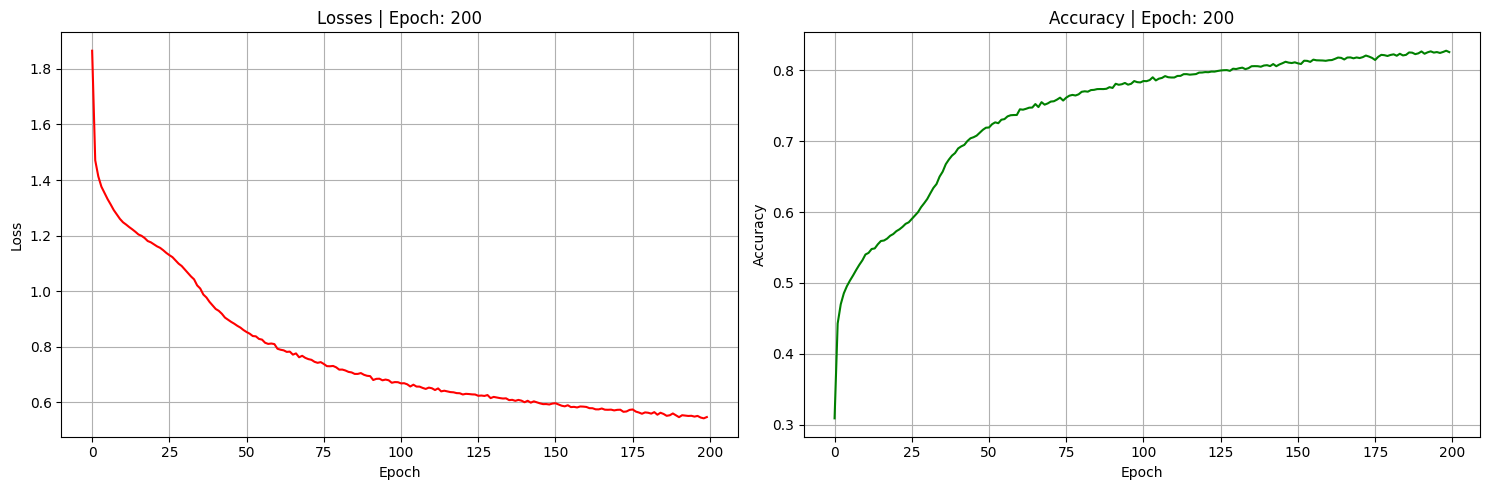

In [27]:
plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
plt.plot(train_losses, color='red', label='Train loss')
plt.title(f"Losses | Epoch: {EPOCHS}")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_acc, color='green', label='Train acc')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title(f"Accuracy | Epoch: {EPOCHS}")
plt.grid()

plt.tight_layout()
plt.show()

# Test

In [28]:
model.eval()

true_labels = list()
pred_labels = list()
pred_probs = list()
test_loss = 0
total_samples = 0

with torch.no_grad():

  for test_batch in tqdm(test_loader, desc="Evaluating Model ... "):
    images, labels = test_batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = model(images)

    preds = torch.argmax(outputs, dim=1)

    # loss
    loss = loss_func(outputs, labels)
    test_loss += loss.item() * images.size(0)
    total_samples += images.size(0)

    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(preds.cpu().numpy())
    pred_probs.append( nn.functional.softmax(outputs, dim=1).cpu().numpy() ) # wanna get probs of each class, for roc-auc

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
avg_test_loss = test_loss / total_samples
pred_probs = np.vstack(pred_probs)

roc_auc = roc_auc_score(true_labels, pred_probs, multi_class='ovr', average='macro')

Evaluating Model ... : 100%|██████████| 79/79 [00:00<00:00, 111.04it/s]


In [29]:
print(f"""ROC-AUC : {roc_auc:.4f}""")

print(
  classification_report(
    true_labels, pred_labels, zero_division=1
  )
)

ROC-AUC : 0.9849
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       980
           1       0.96      0.99      0.98      1135
           2       0.77      0.65      0.71      1032
           3       0.86      0.90      0.88      1010
           4       0.94      0.83      0.88       982
           5       0.78      0.85      0.81       892
           6       0.81      0.72      0.77       958
           7       0.83      0.94      0.88      1028
           8       0.91      0.77      0.84       974
           9       0.79      0.84      0.82      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



## Confusion matrix

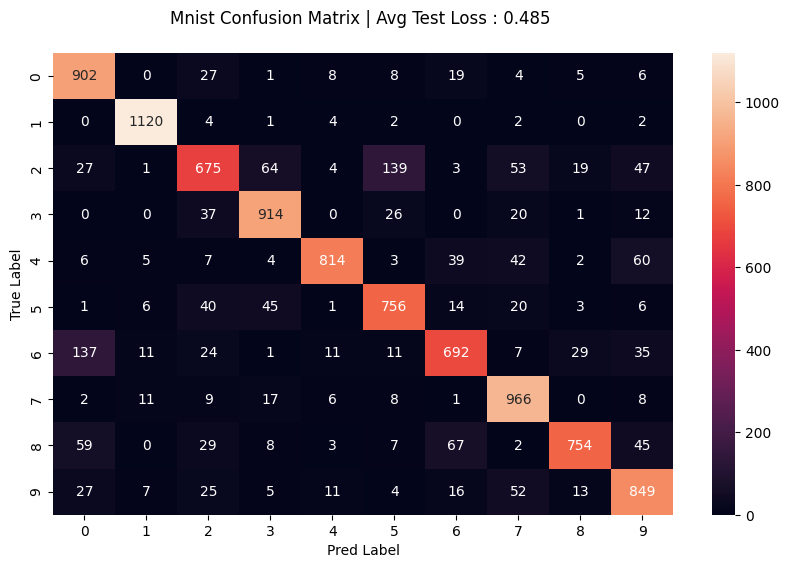

In [30]:
conf = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 6))
sns.heatmap(conf, annot=True, fmt='d')
plt.xlabel("Pred Label")
plt.ylabel("True Label")
plt.title(f"Mnist Confusion Matrix | Avg Test Loss : {avg_test_loss:.3f} \n")
plt.show()

## Receiver operating characteristic - Area under curve
- one vs rest .. because this is multi-class .. to be able to tell, how the model is able to distinguish between the 10 different classes .. from the graph the model is doing well .. line from (0,0) to (1,1) tells that the model is not able to distinguish between false positive rate and true positive rate, but from the graph below the model is well and can distinguish between classes : true positive rate != false positive rate

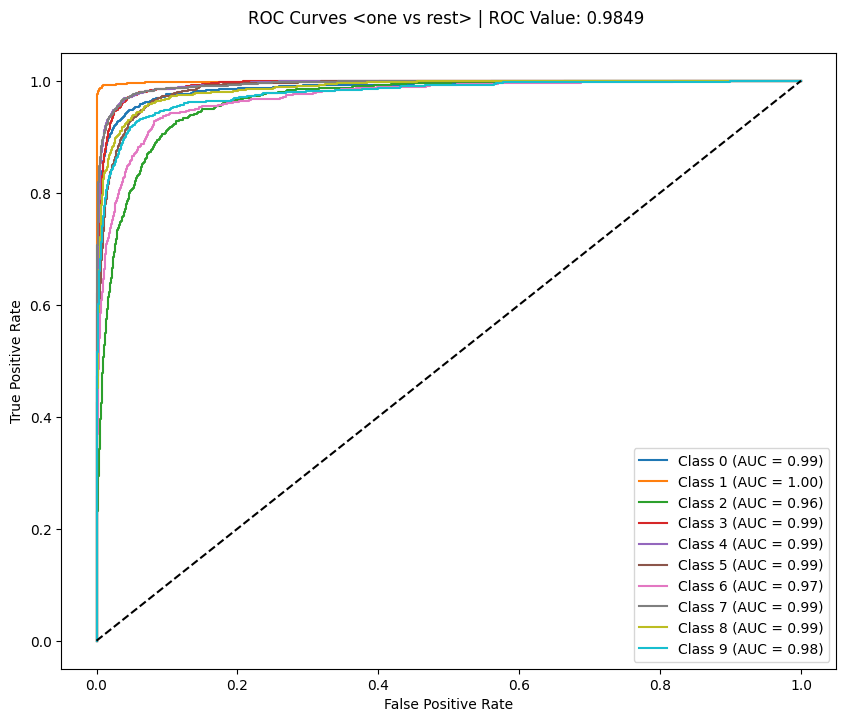

In [31]:


plt.figure(figsize=(10, 8))
for class_ in range(NUM_CLASSES):
  fpr, tpr, _ = roc_curve(true_labels == class_, pred_probs[:, class_])
  plt.plot(fpr, tpr, label=f'Class {class_} (AUC = {roc_auc_score(true_labels == class_, pred_probs[:, class_]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves <one vs rest> | ROC Value: {roc_auc:.4f} \n')
plt.legend()
plt.show()

In [32]:
# end - wandb
wandb_run.finish()

epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
train_accuracy,▁▁▂▂▄▄▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,██▇▆▆▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,200
train_accuracy,0.82567
train_loss,0.5473
